# Recommendations with IBM

In this project, we will building recoomendation system based on real data from the IBM Watson Studio platform. 



## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>


Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Let's dive into the descriptive statistics of the data.


In [3]:
articles_per_user = df.groupby(by=['email'])['article_id'].count()
articles_per_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

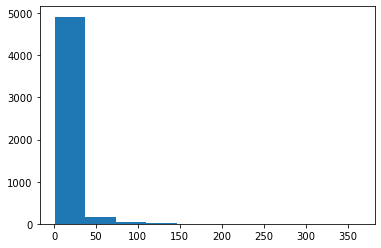

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='article_id'>

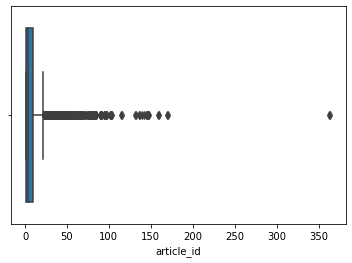

In [4]:
plt.hist(articles_per_user)
plt.show()
sns.boxplot(articles_per_user)

In [5]:
median_val = articles_per_user.median()
max_views_by_user = articles_per_user.max()

median_val, max_views_by_user

(3.0, 364)

Based on above, we understand that:
1. 50% of individuals interact with 3 number of articles or fewer.
2. The maximum number of user-article interactions by any 1 user is 364


Next, we will remove duplicate articles from the **df_content** dataframe

In [6]:
print(df_content.shape[0])
df_content = df_content.drop_duplicates(subset='article_id', keep='first')
print(df_content.shape[0])


1056
1051


The following cells will help understand the following:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
print(df.shape)
df.drop_duplicates(subset=['article_id', 'email'], keep='first').shape[0]

(45993, 3)


33682

In [8]:
# The number of unique articles that have at least one interaction
unique_articles = (df.groupby('article_id')['email'].count() > 0).sum()

# The number of unique articles on the IBM platform
total_articles = len(df_content['article_id'].unique())

# The number of unique users
unique_users = len(df['email'].unique()) - pd.Series(df['email'].unique()).isnull().sum()

# The number of user-article interactions
user_article_interactions = df.shape[0]

Below we will find the most viewed **article_id**, as well as how often it was viewed.  The `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
most_viewed = pd.Series(df.groupby('article_id')['email'].count())


In [10]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = most_viewed.idxmax().astype('str')

# The most viewed article in the datase
max_views = most_viewed.max()

In [11]:
def email_mapper():
    '''
    Maps the user email to a user_id column and removes the email column
    '''
    
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unfortunately, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.


In [12]:
def get_top_articles(n, df=df):
    '''
    Returns the top article titles from df 
    
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''

    top_articles = df.groupby('title')['title'].count().sort_values(ascending=False).head(n).index
    top_articles = list(top_articles)
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    Returns the top article ids
    
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    
    top_articles = df.groupby('article_id')['article_id'].count().sort_values(ascending=False).head(n).index
    top_articles = list(top_articles)
    top_articles = [str(i) for i in top_articles]
    
    return top_articles

In [13]:
# Top 10 most popular articles and their ids

print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


The function below reformats the **df** dataframe to be shaped with users as the rows and articles as the columns.  


In [14]:
def create_user_item_matrix(df):
    '''    
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    user_item[user_item.isnull()] = 0
    user_item[user_item >= 1] = 1
    
    return user_item

user_item = create_user_item_matrix(df)

In [15]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # compute similarity of each user to the provided user
    similarity = user_item[user_item.index==user_id].dot(np.transpose(user_item))
    # sort by similarity
    similarity = similarity.sort_values(by=user_id, ascending=False, axis=1)
    
    # create list of just the ids
    most_similar_users = similarity.columns.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [16]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [17]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    Description:
    Returns article names from article id
    
    '''
    article_names = set(df[df['article_id'].isin(article_ids)]['title'])
    
    return list(article_names)

def get_user_articles(user_id, user_item=user_item):
                       
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids_i = np.where(user_item.loc[user_id] == 1)[0] # Get indices where condition is met
    article_ids = user_item.iloc[user_id-1, article_ids_i].index.tolist()
    article_ids = [str(i) for i in article_ids]
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    most_similar_users = find_similar_users(user_id)
    articles_seen, _ = get_user_articles(user_id, user_item=user_item)
    recs = []

    for neighbor in most_similar_users:
        neighbor_seen, _ = get_user_articles(neighbor, user_item=user_item)
        new_recs = np.setdiff1d(neighbor_seen, articles_seen, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > m-1:
            recs = recs[:m]
            break
        
    
    return recs

In [18]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'analyze facebook data using ibm watson and watson studio',
 'data tidying in data science experience',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'analyze energy consumption in buildings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: vancouver listings',
 'a tensorflow regression model to predict house values',
 'analyze accident reports on amazon emr spark',
 'airbnb data for analytics: mallorca reviews']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we'll choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [19]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # compute similarity of each user to the provided user
    similarity = user_item[user_item.index==user_id].dot(np.transpose(user_item))
    # sort by similarity
    similarity = similarity.sort_values(by=user_id, ascending=False, axis=1)
    similarity = similarity.drop(user_id, axis=1)

    num_interactions = df.groupby('user_id').count()['article_id']
    num_interactions = num_interactions.drop(labels=user_id)

    neighbors_df = pd.DataFrame(data={'neighbor_id': similarity.columns, 'similarity': similarity.values[0]}).set_index('neighbor_id')
    neighbors_df = pd.concat([neighbors_df, num_interactions], axis=1).rename(columns={'article_id': 'num_interactions'})
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)

    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    most_similar_users = get_top_sorted_users(user_id, df=df, user_item=user_item).index
    articles_seen, _ = get_user_articles(user_id, user_item=user_item)
    recs = np.array([])

    for neighbor in most_similar_users:
        neighbor_seen, _ = get_user_articles(neighbor, user_item=user_item)
        new_recs = np.setdiff1d(neighbor_seen, articles_seen, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > m-1:
            recs = recs[:m]
            break
    
    rec_names = get_article_names(recs)
            
    return recs, rec_names

In [20]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: venice listings', 'airbnb data for analytics: chicago listings', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'tensorflow quick tips', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'analyze accident reports on amazon emr spark']


In [21]:

user1_most_sim = get_top_sorted_users(1).index[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index[9] # Find the 10th most similar user to user 131

print(user1_most_sim)
print(user131_10th_sim)

3933
242


If we were given a new user it makes sense to recommend the most popular articles since we do not know anything about this user. Hence, function `get_top_article_ids()` would be used.




In [22]:
new_user = '0.0'

new_user_recs = get_top_article_ids(10)

What would our recommendations be for new user '0.0'?  As a new user, they have no observed articles.
A list of the top 10 article ids for this user would look like this.

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

We should have already a **user_item** matrix in **Part III** above. 

In [23]:
# Loading the stored matrix 
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [24]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this situation, we can use Singular Value Decomposition from numpy on the user-item matrix.  

In [25]:
# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In [26]:
user_item_matrix.isnull().sum().sum()

0

In this case, traditional SVD can be used as there are no missing values. It is important to highlight that SVD will fail in case there are missing values, so FunkSVD should be used instead.

Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

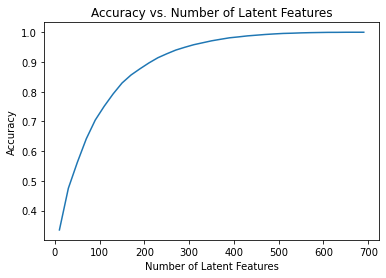

In [27]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of whether we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Using the code earlier we will try to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [28]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    train_idx = df_train['user_id'].unique()
    test_idx = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [29]:
print("How many users can we make predictions for in the test set? \n {} \n\n".format(len(np.intersect1d(df_train['user_id'].unique(), test_idx))))
print("How many users are we not able to make predictions for because of the cold start problem? \n {} \n\n".format(len(test_idx) - len(np.intersect1d(df_train['user_id'].unique(), test_idx))))
print("How many articles can we make predictions for in the test set?   \n {} \n\n".format(len(np.intersect1d(df_train['article_id'].unique(), test_arts))))
print("How many articles are we not able to make predictions for because of the cold start problem? \n {} \n\n".format(len(test_arts) - len(np.intersect1d(df_train['article_id'].unique(), test_arts))))


How many users can we make predictions for in the test set? 
 20 


How many users are we not able to make predictions for because of the cold start problem? 
 662 


How many articles can we make predictions for in the test set?   
 574 


How many articles are we not able to make predictions for because of the cold start problem? 
 0 




Now we will use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then we find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

Using the cells below we will explore how well SVD works towards making predictions for recommendations on the test data.  

In [30]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)


In [31]:
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


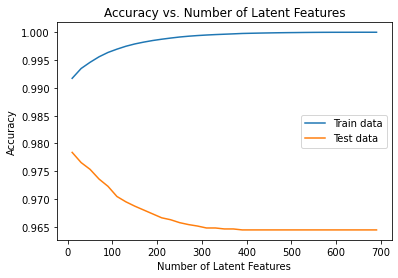

In [32]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train, sum_errs_test = [], []
com_users = np.intersect1d(df_train['user_id'].unique(), test_idx)

com_users_idx_i = user_item_train.index.isin(test_idx)
u_test = u_train[com_users_idx_i]

com_arts_i = user_item_train.columns.isin(test_arts)
vt_test = vt_train[:, com_arts_i]

for k in num_latent_feats:
    # restructuring with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]
    # taking dot product for train and test datasets
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    
    # computing error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test.loc[com_users], user_item_est_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), label='Train data');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.loc[com_users].shape[0]*user_item_test.loc[com_users].shape[1]), label='Test data');

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend()


Based on the above figure, we can conclude that by adding more latent features, our model tends to overfit. For our model to generalize better and to achieve maximum accuracy, it's prefered to keep the number of latent features to minimum.

The above recommendations are definetely of value for IBM.
We used Matrix Factorization with SVD to predict whether users will interact with articles and achieved the accuracy of 0.979 on a test data set with 10 latent features.

Unfortunately, we could not make predictions for most of the users in a test data set because of cold start problem. In fact, we could only make predictions for 20 users (2.93% of all users in a test dataset). When we run into cold start problem, we should implement content based and ranked based recommendations.

For users that have interacted with a few articles, a combination of rank-based recommendations, User-User Based Collaborative Filtering and Content Based Recommendations can be used.

The main drawback of the recommendations systems implemented above is that the findings are observational ('off-line'). To truly validate our assumptions, we need to run A/B test and divide the audience into groups where one of the groups should be a control group. This will help us determine the best approach and choose the best recommendation method or a combination of methods.